In this notebook, we extract significantly spatially varying genes and show them in three clusters.

Load relevant packages, including SpatialDE:

In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import pickle as pickle
import scipy as sc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [3]:
adata = pickle.load(open('data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Choose the data from 19pcw replicates at radial position 2:

In [15]:
subset_19pcw = [adata.obs['Radial_position'][i] == 2 and
                adata.obs['slide'][i] == '00MU' and 
                adata.obs['age'][i] == '19pcw' for i in range(np.shape(adata.obs)[0])]

KeyError: 'Slide'

Initialize our risk gene sets:

In [5]:
autism = pd.read_csv('riskGenes/AutismGenes_Satterstrom2020.csv')
autism = np.array(autism['gene'])
brainsize = pd.read_csv('riskGenes/BrainsizeGenes_Grasby2020.csv', skiprows = 2)
subset = np.array(('Average Thickness', 'Banks of the Superior Temporal Sulcus', 'Inferior Temporal', 'Middle Temporal', 'Superior Temporal', 'Total Surface Area'))
brainsize = np.array(brainsize['Gene name'][np.array([brainsize['Phenotype'][i] in subset for i in range(len(brainsize['Phenotype']))])])
ID = pd.read_csv('riskGenes/DDG2P_10_5_2020.csv')
organSpecificity = np.array(ID['organ specificity list'])
ID = ID.loc[~pd.isna(organSpecificity),:]
organSpecificity = np.array(ID['organ specificity list'])
organSpecificity = [organSpecificity[i].split(';') for i in range(len(organSpecificity))]
brainCognition = np.array([sum([organSpecificity[i][j] == 'Brain/Cognition' for j in range(len(organSpecificity[i]))]) > 0 for i in range(len(organSpecificity))])
ID = ID.loc[brainCognition,:]
ID = np.array(ID['gene symbol'])
IQ = pd.read_csv('riskGenes/IQGenes_Savage2018.csv', skiprows=4)
IQ = np.array(IQ.iloc[:507,:]['Gene Name'])

Calculate average z-scored expression, using corrected counts:

In [9]:
adata.obs['TotalCounts_corrected'] = np.sum(adata.layers['X_Corrected_V2'], axis = 1)+0.1
adata.layers['CPM_corrected'] = np.asarray([adata.layers['X_Corrected_V2'][i,:]/adata.obs['TotalCounts_corrected'][i] for i in range(len(adata.obs['TotalCounts_corrected']))])*10**6
adata.layers['zscore_19pcw_corrected'] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected']+1), axis = 0)
adata.layers['zscore_19pcw_corrected'][subset_19pcw,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_19pcw,:]+1), axis = 0)

In [10]:
brainsize_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in brainsize for i in range(len(adata.var_names))]], axis = 1)
autism_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in autism for i in range(len(adata.var_names))]], axis = 1)
ID_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in ID for i in range(len(adata.var_names))]], axis = 1)
IQ_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in IQ for i in range(len(adata.var_names))]], axis = 1)
All_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw,:], axis = 1)

Make a plot of average z-scored expression:

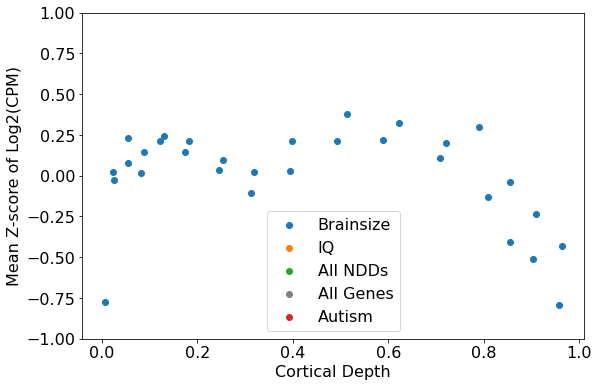

In [11]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

corticalDepth = adata.obs['VCDepth'][subset_19pcw]

plt.figure(figsize=(9,6))

plt.scatter(corticalDepth, brainsize_average, label = 'Brainsize')
plt.scatter(corticalDepth, IQ_average, label = 'IQ')
plt.scatter(corticalDepth, ID_average, label = 'All NDDs')
plt.scatter(corticalDepth, All_average, label = 'All Genes', c = 'grey')
plt.scatter(corticalDepth, autism_average, label = 'Autism')
plt.xlabel('Cortical Depth')
plt.ylabel('Mean Z-score of Log2(CPM)')
plt.ylim(-1,1)
plt.legend()

plt.savefig('0_publication_figures/Figure2_RiskGenes_MeanZscore_CC-V2.pdf')

Now calculate expression relative to average expression of all genes at that position:

In [12]:
All_average = np.mean(adata.layers['CPM_corrected'][subset_19pcw,:], axis = 1)

brainsize_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in brainsize for i in range(len(adata.var_names))]], axis = 1)/All_average
autism_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in autism for i in range(len(adata.var_names))]], axis = 1)/All_average
ID_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in ID for i in range(len(adata.var_names))]], axis = 1)/All_average
IQ_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw,:][:,
                            [adata.var_names[i] in IQ for i in range(len(adata.var_names))]], axis = 1)/All_average

All_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw,:], axis = 1)/All_average


In [13]:
autism_relative

array([2.28071319, 1.70343711, 1.65424968, 3.13045318, 1.77820219,
       1.82240105, 3.39236529, 1.98377576, 1.81826603, 3.33183337,
       1.96880305, 1.72513366, 3.12400474, 2.25949982, 1.72403868,
       2.63906333, 1.72016323, 1.68373336, 2.95818598, 1.70061962,
       1.75277961, 2.92321737, 1.64759486, 1.68502812, 2.7780774 ,
       1.76425526, 1.71862227, 1.98138211, 1.71967215, 2.02177856,
       1.72304631])

Now calculate expression as percentage of mean average gene counts (relative expression):

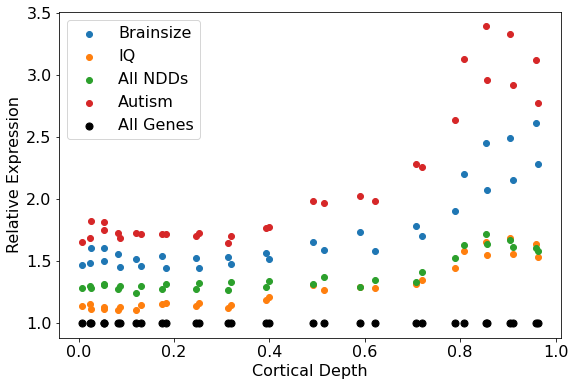

In [14]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


corticalDepth = adata.obs['VCDepth'][subset_19pcw]

plt.figure(figsize=(9,6))

plt.scatter(corticalDepth, brainsize_relative, label = 'Brainsize')
plt.scatter(corticalDepth, IQ_relative, label = 'IQ')
plt.scatter(corticalDepth, ID_relative, label = 'All NDDs')
plt.scatter(corticalDepth, autism_relative, label = 'Autism')
plt.scatter(corticalDepth, All_relative, label = 'All Genes', c = 'black', s = 50)
plt.xlabel('Cortical Depth')
plt.ylabel('Relative Expression')
plt.legend()
plt.savefig('0_publication_figures/Figure2_RiskGenes_RelativeExpression.pdf')

In [12]:
subset_19pcw_2 = [adata.obs['Radial_position'][i] == 2 and
                  adata.obs['slide'][i] == '00MU' and
                  adata.obs['age'][i] == '19pcw' for i in range(np.shape(adata.obs)[0])]

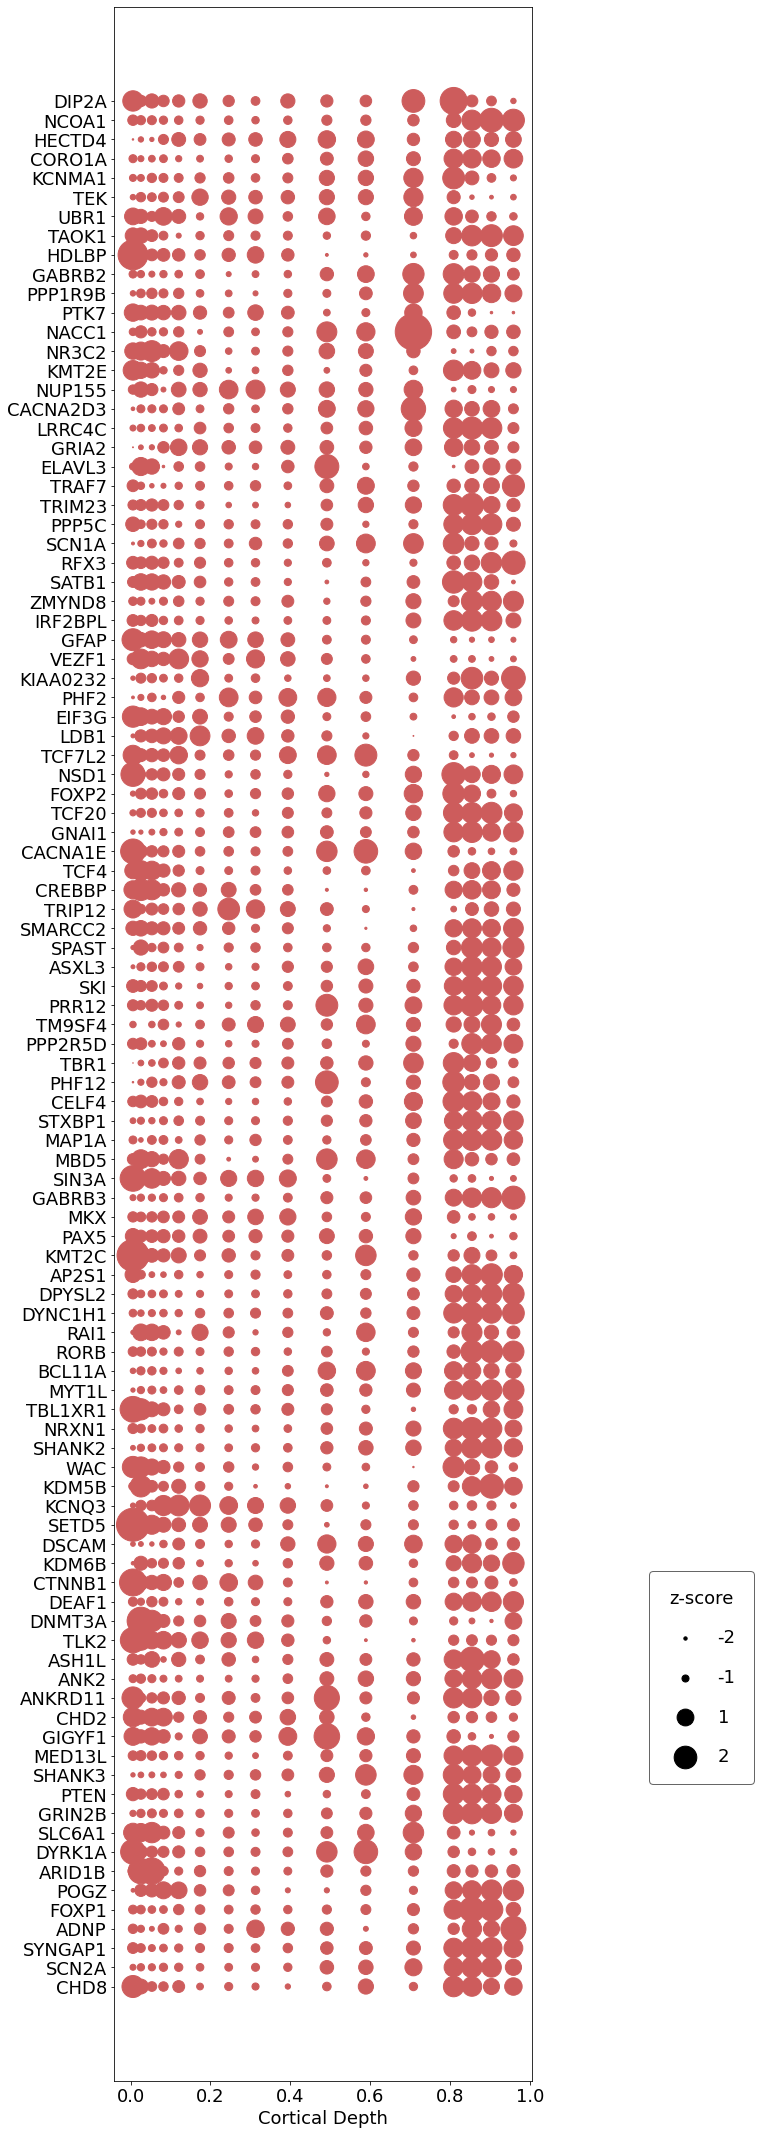

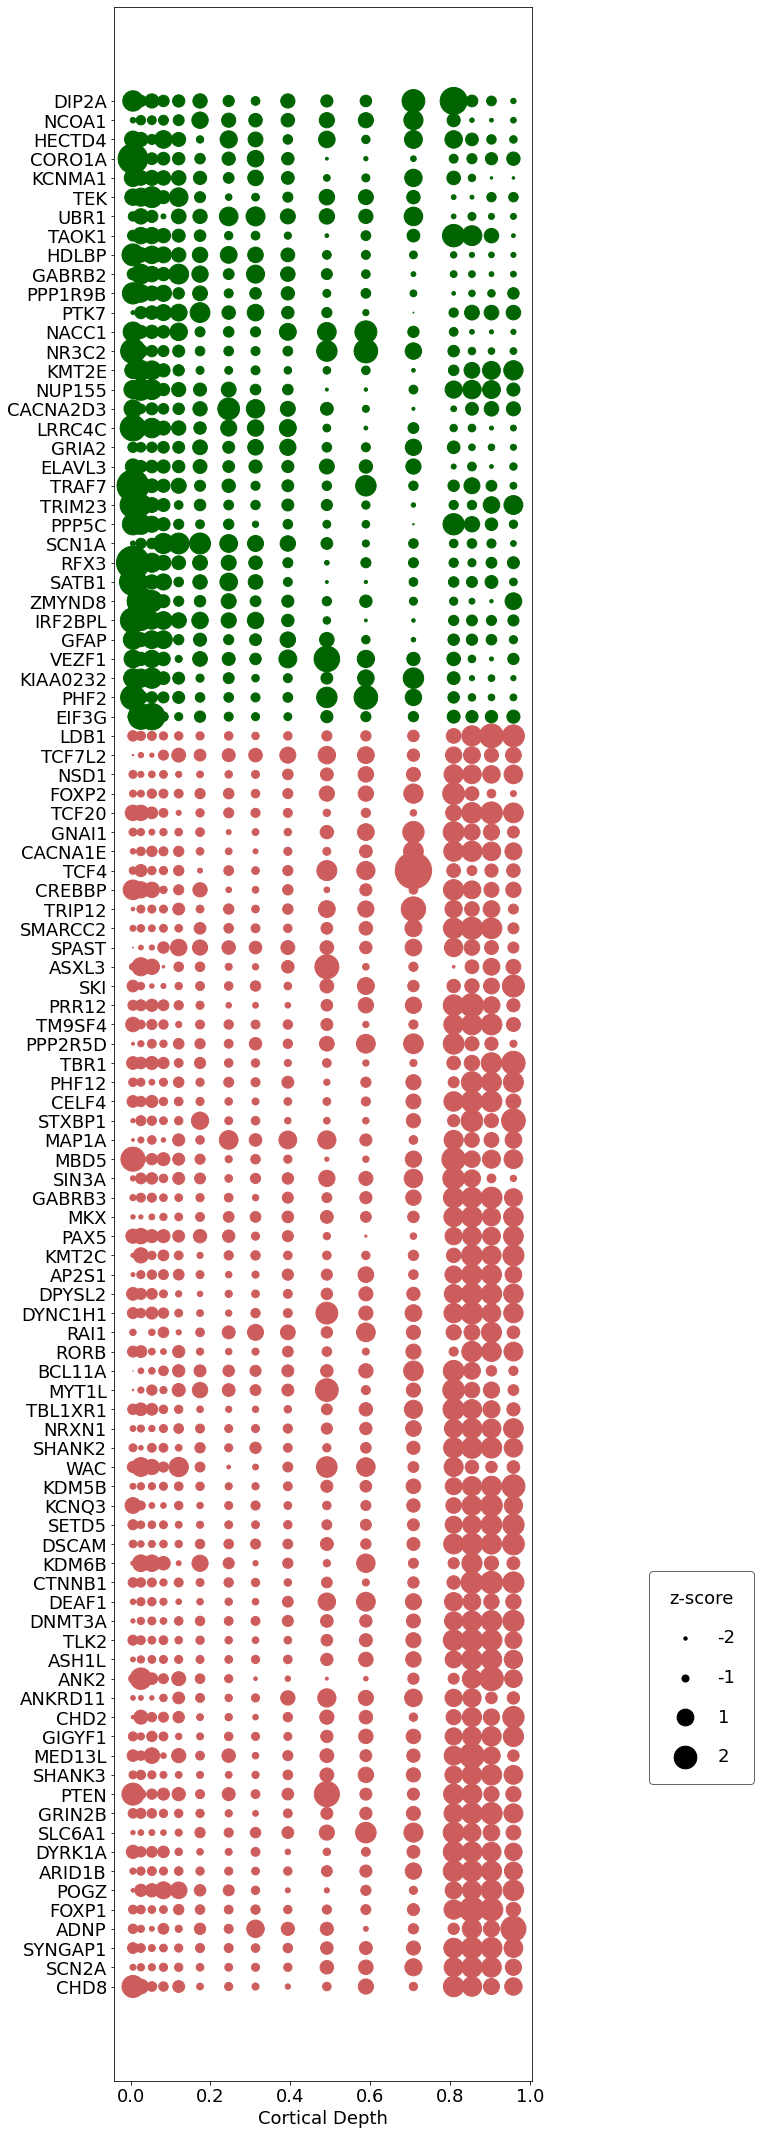

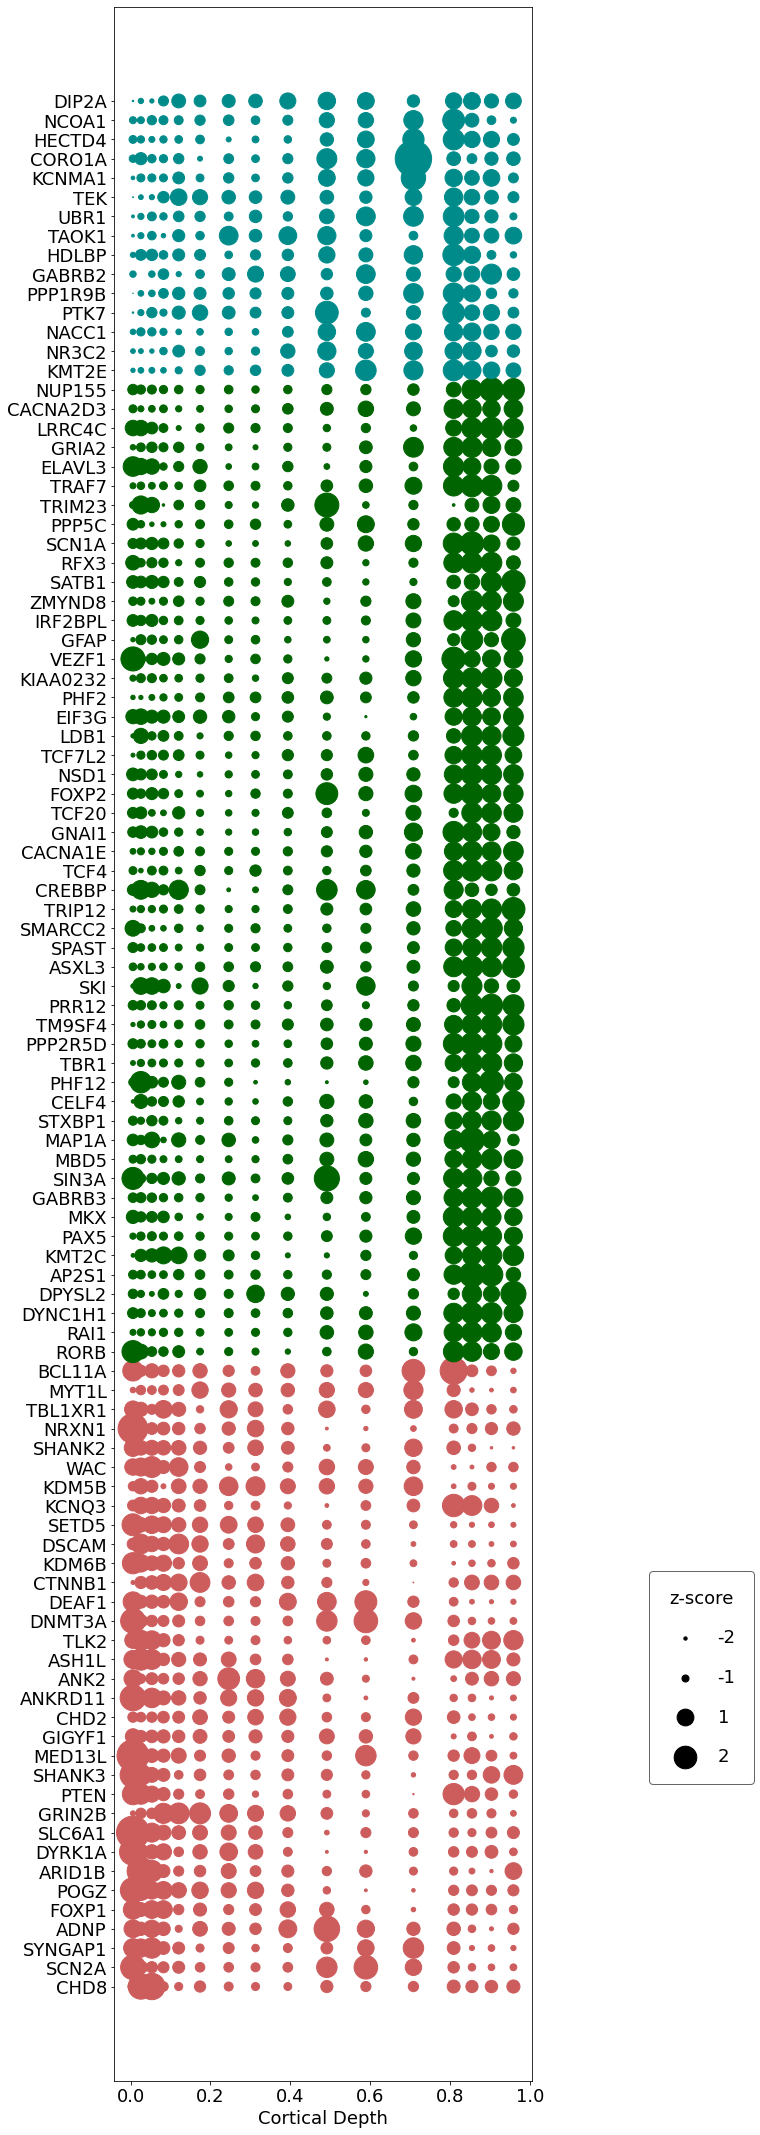

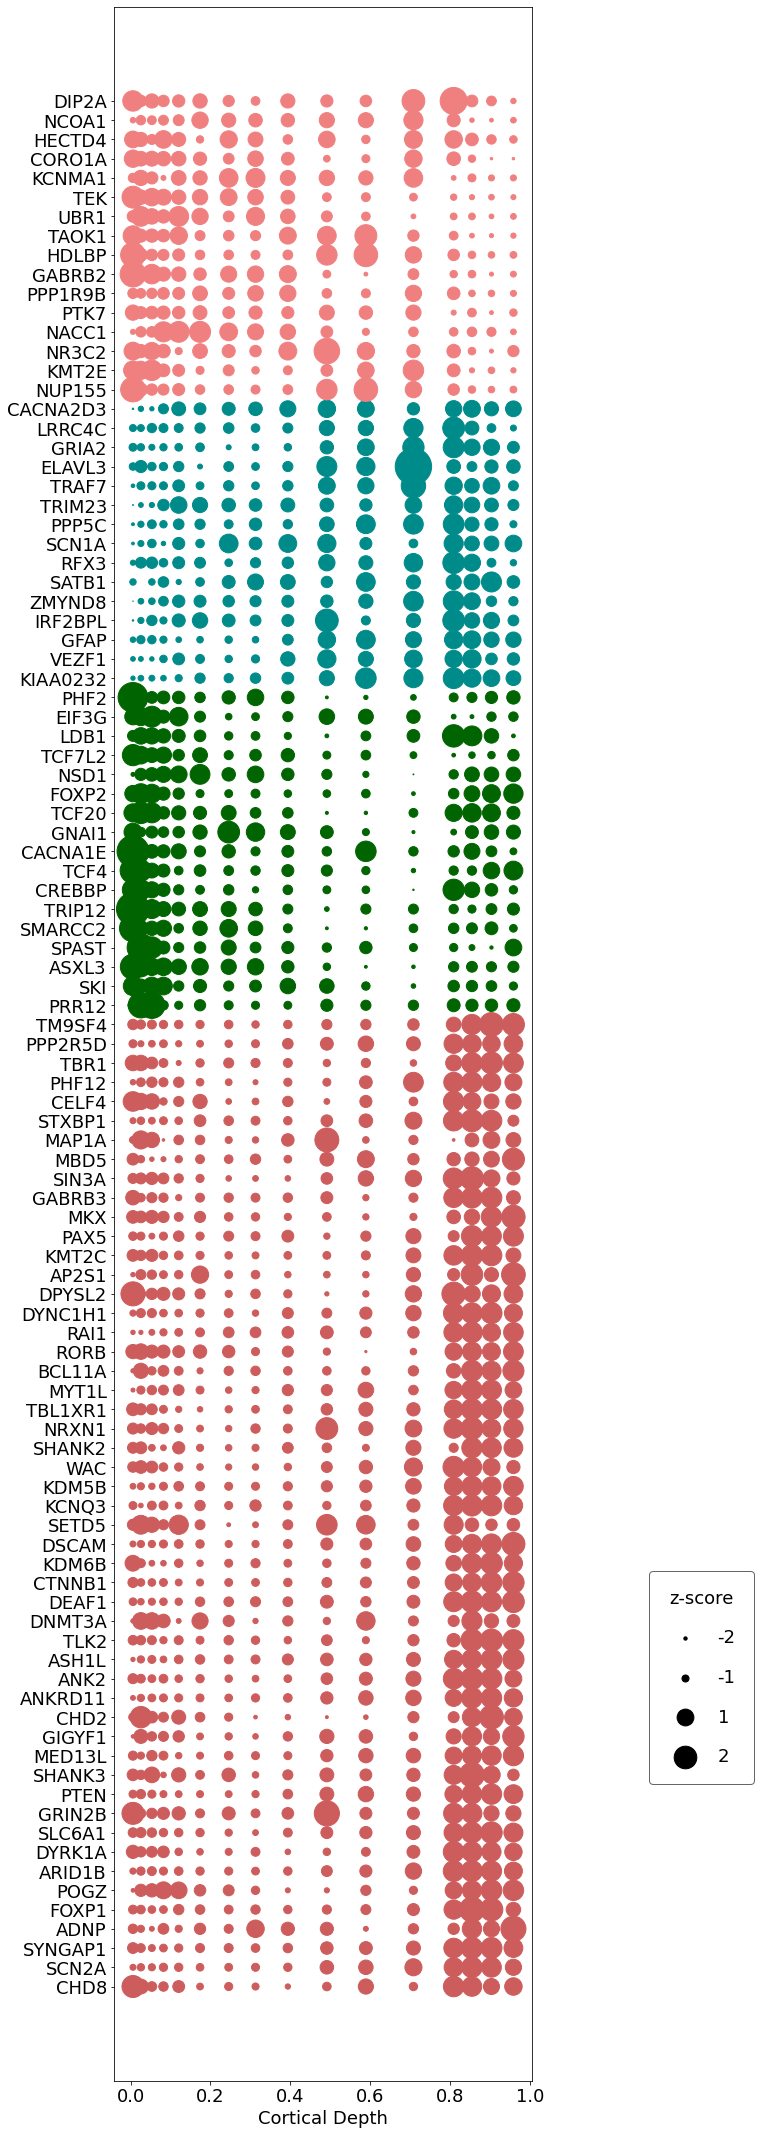

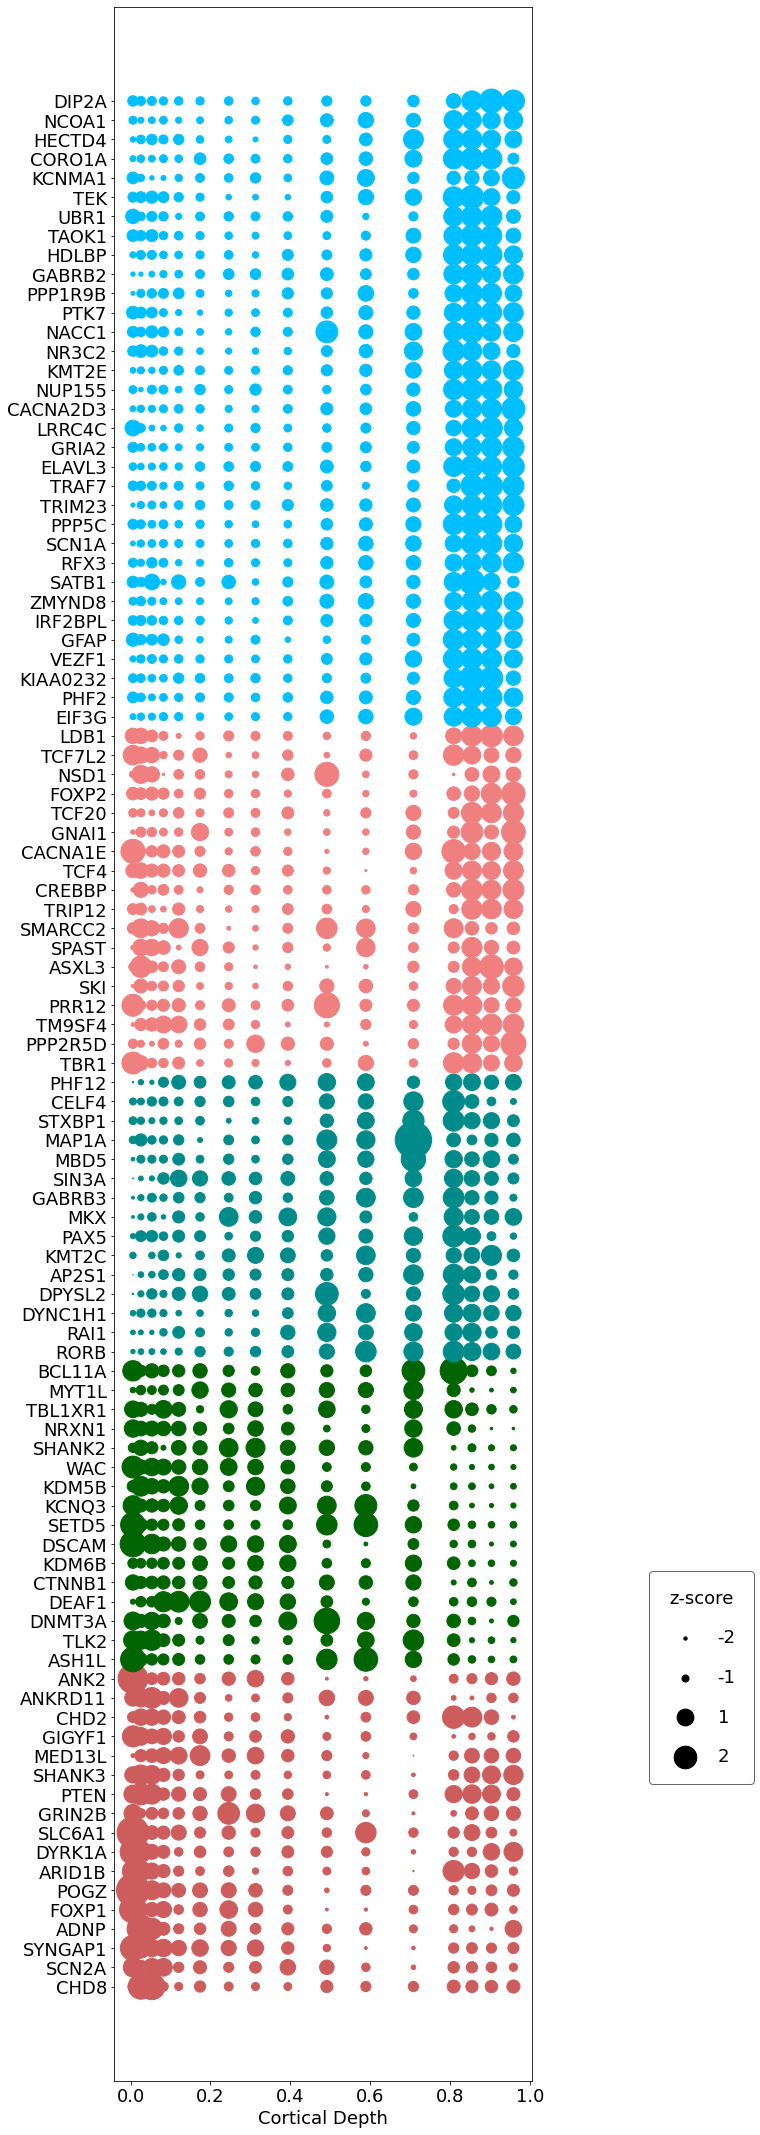

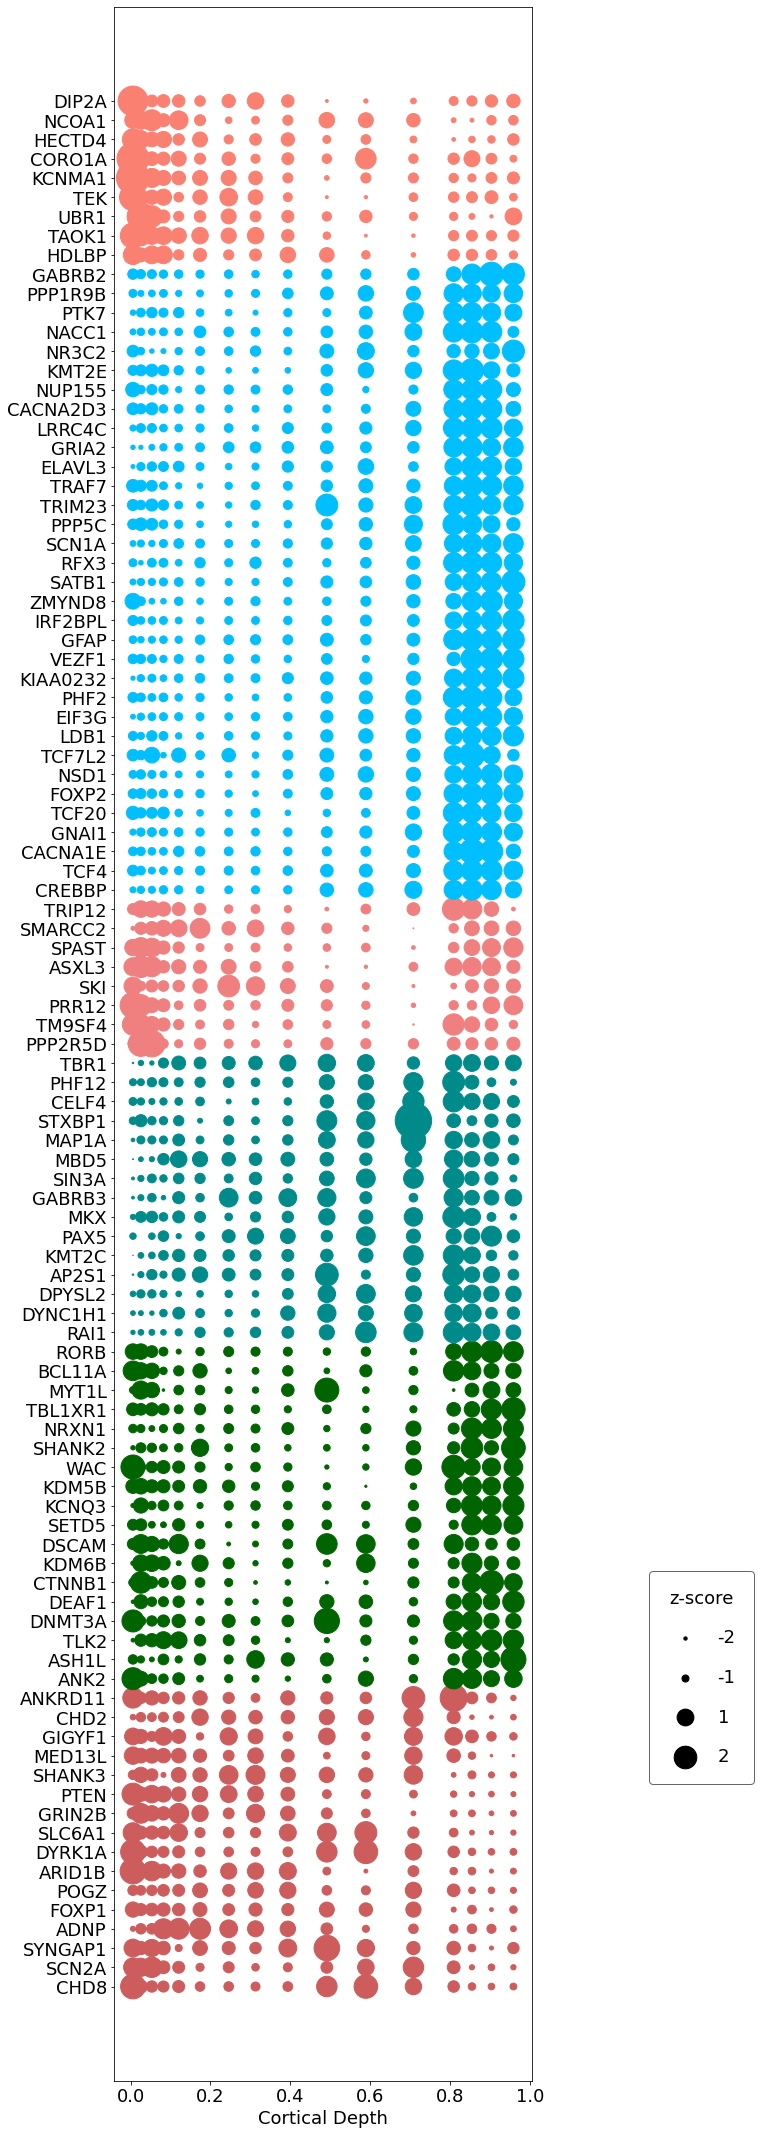

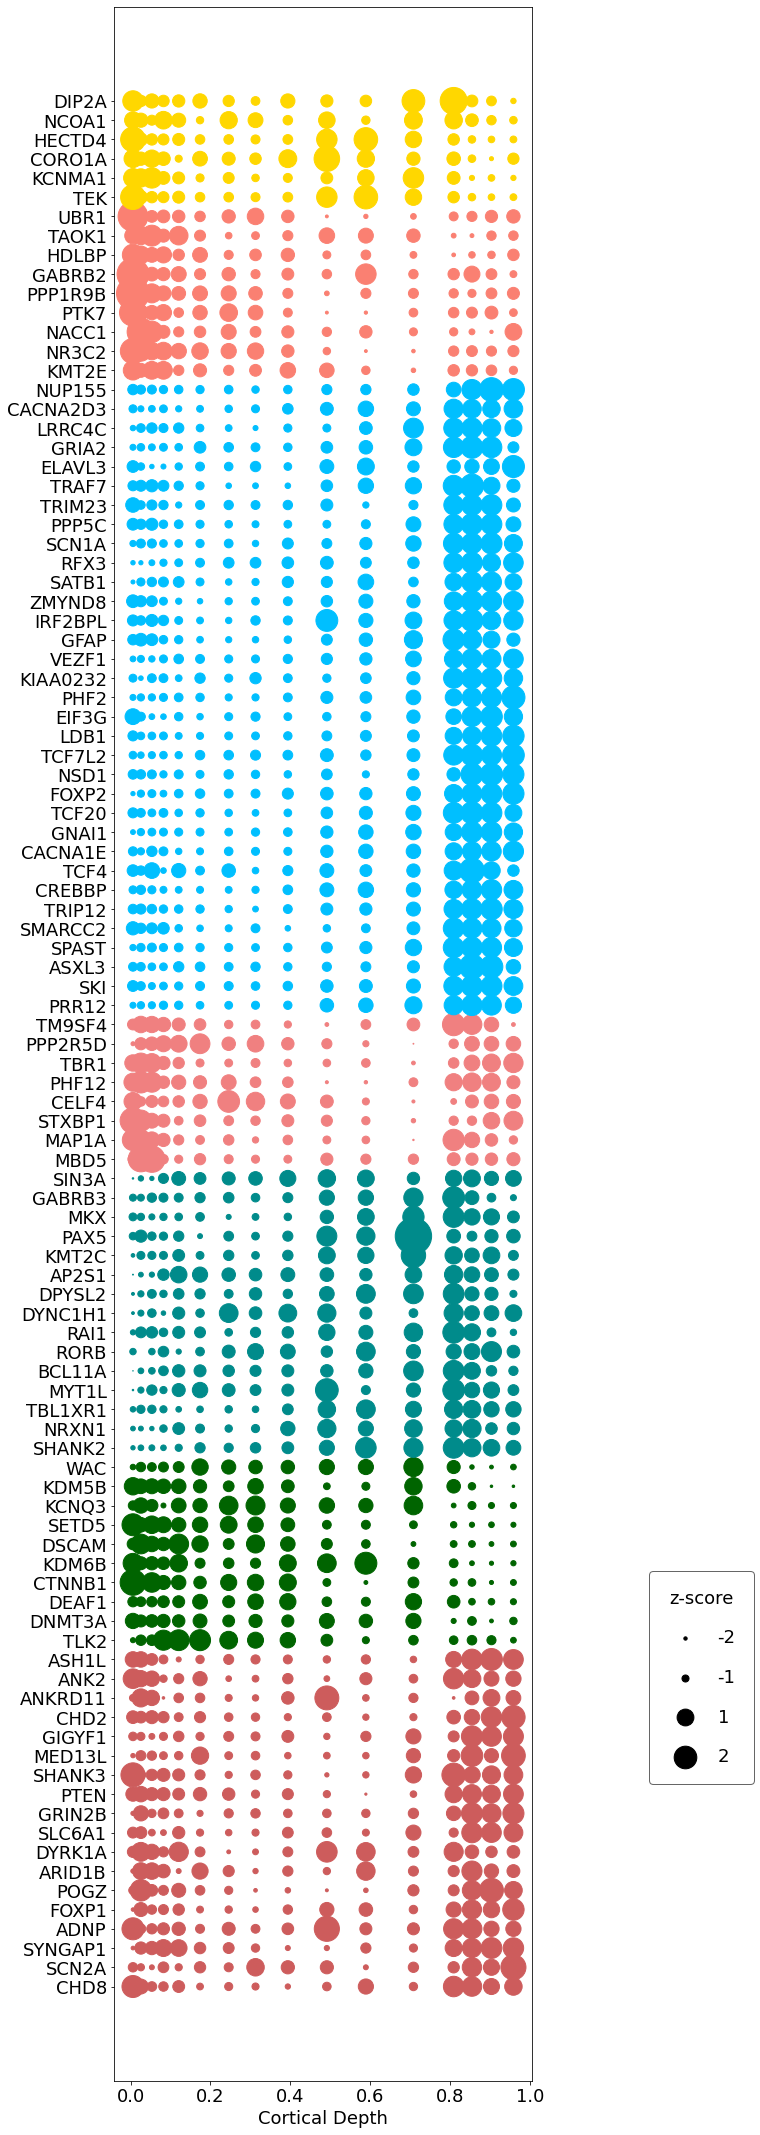

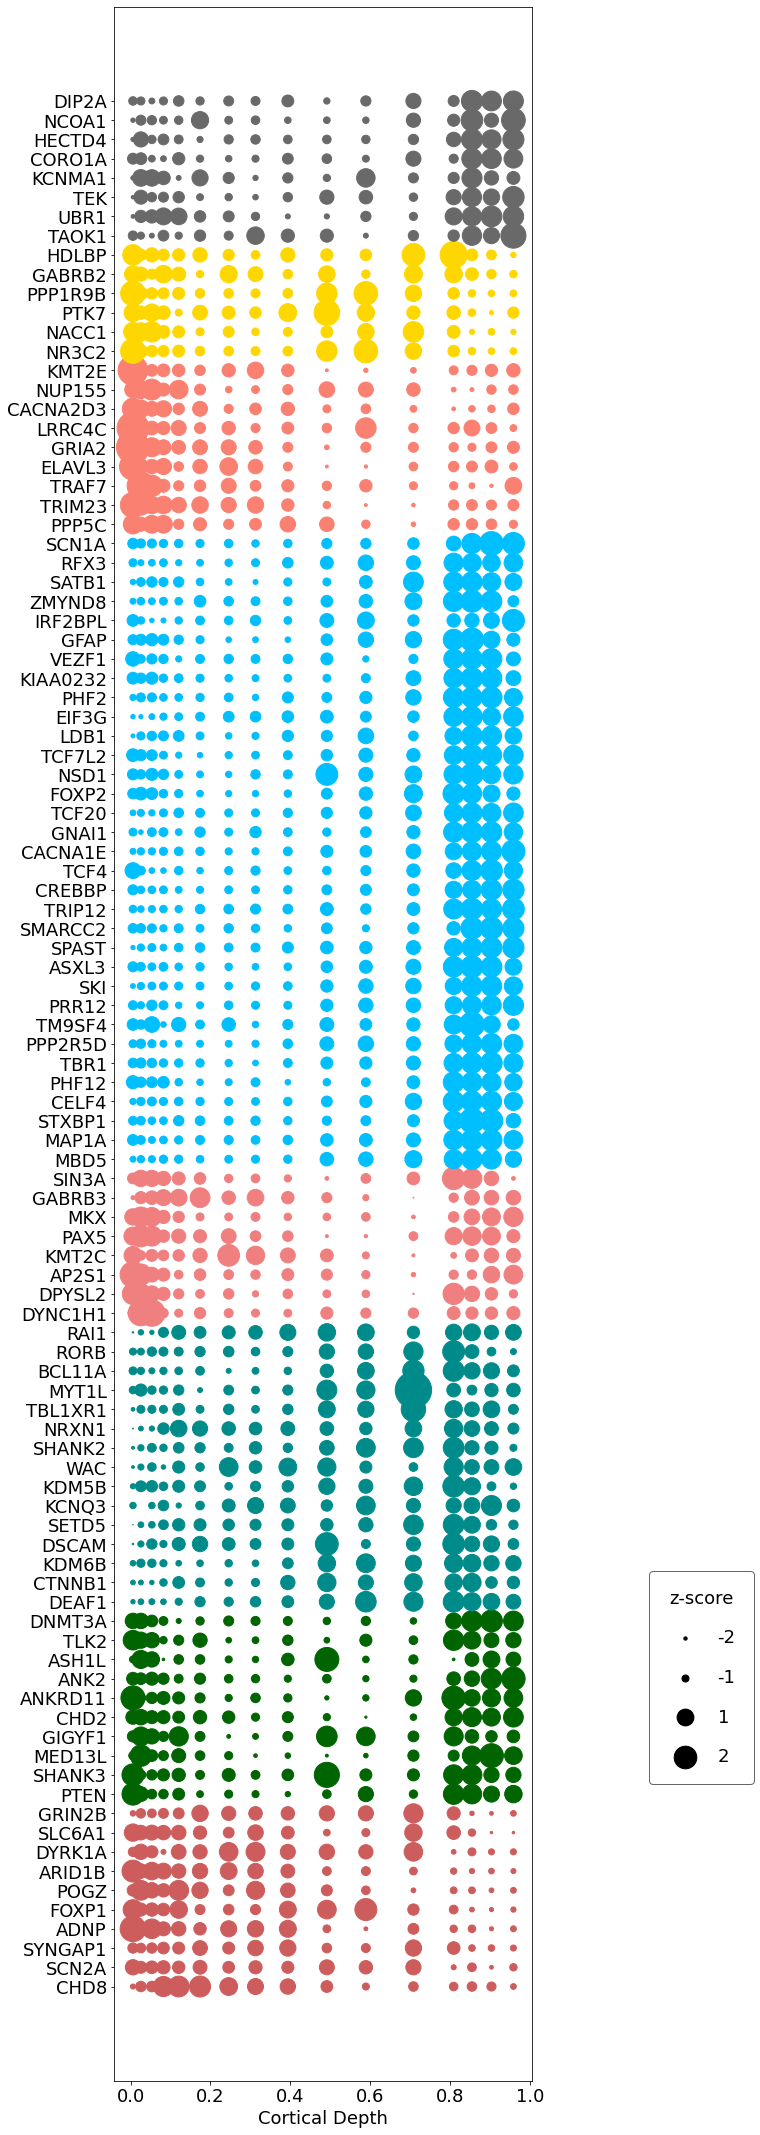

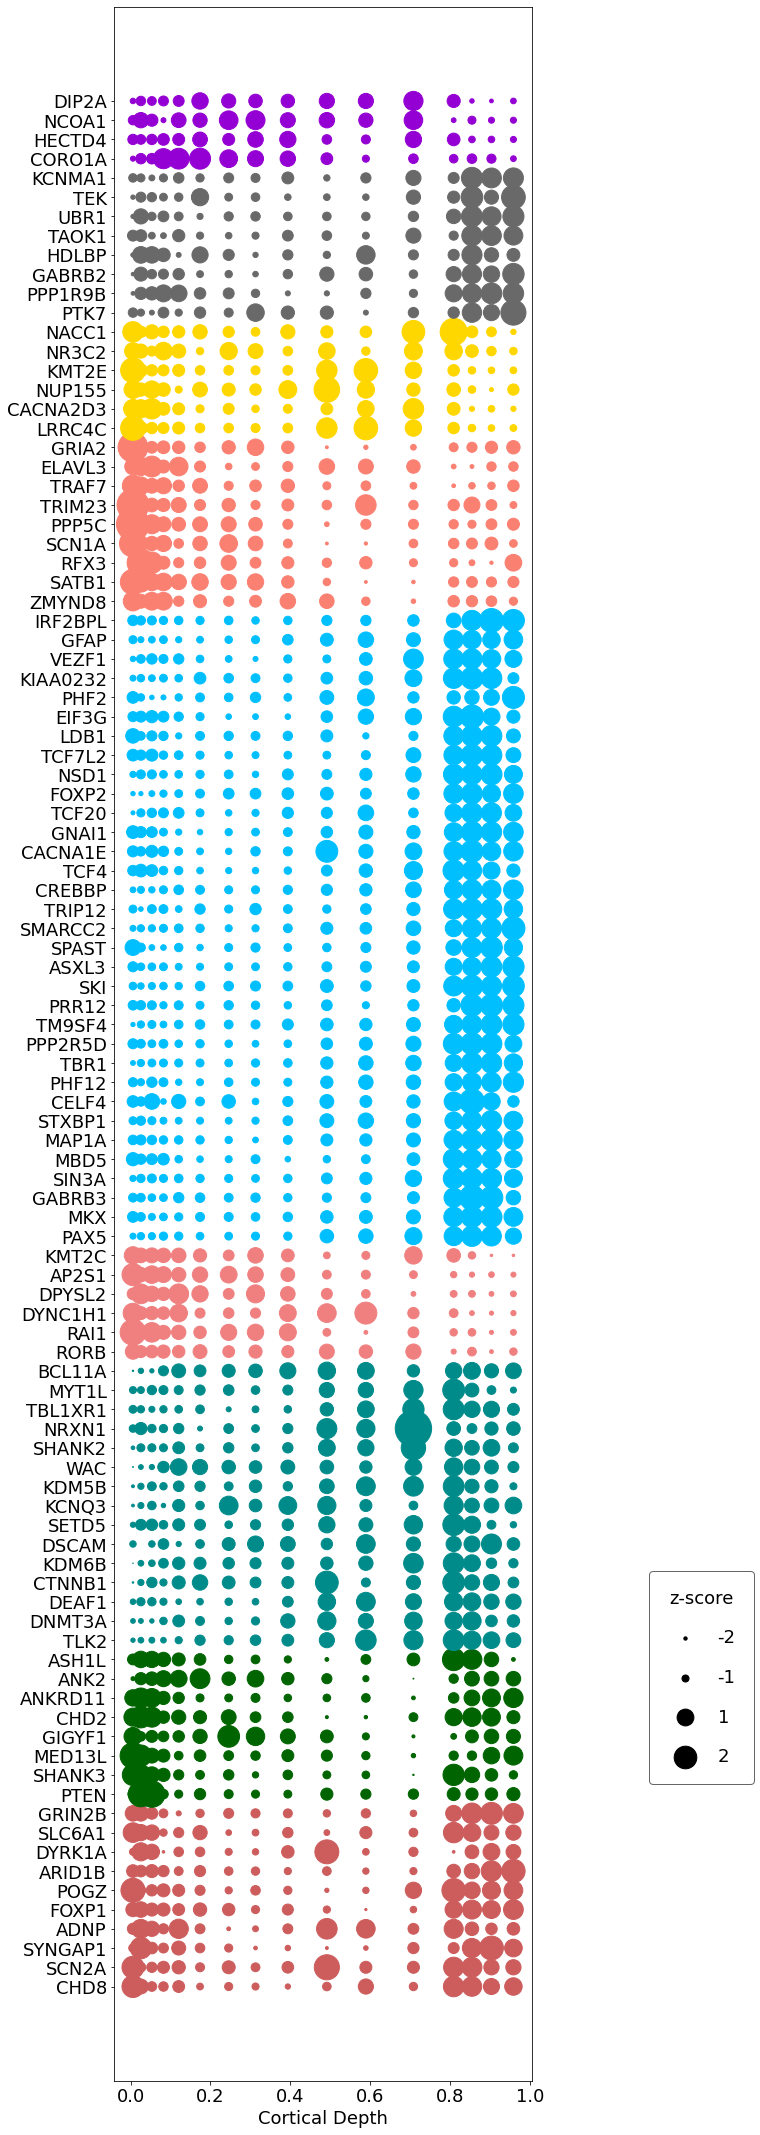

In [49]:
scaling = 3
power = 3

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

for n_clusters in range(1,10):

    markers_genes = autism
    markers_genes = [g for g in markers_genes if g in adata.var_names]

    genesForPlot = np.repeat(markers_genes,sum(subset_19pcw_2))
    vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw_2] for i in range(len(markers_genes))]).flatten()
    countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw_2, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

    # Cluster genes:
    from sklearn.cluster import AgglomerativeClustering
    correlationMatrix = np.corrcoef(countsForPlot)
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    groups = cluster.fit_predict(correlationMatrix)
    markers_genes = np.concatenate([np.array(markers_genes)[groups == i] for i in np.unique(groups)])

    vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw_2] for i in range(len(markers_genes))]).flatten()
    countsForPlot = np.array([adata.layers['zscore_19pcw_corrected'][subset_19pcw_2, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])
    coloursForPlot = np.concatenate([np.repeat(i, sum(groups == i) * sum(subset_19pcw_2)) for i in unique(groups)])

    cmap = ('indianred', 'darkgreen', 'darkcyan', 'lightcoral', 'deepskyblue',
           'salmon', 'gold', 'dimgray', 'darkviolet', 'red', 'lightgreen')
    plt.figure(figsize = (12,30))
    plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
                c = [cmap[x] for x in coloursForPlot])
    plt.xlabel('Cortical Depth')

    plt.subplots_adjust(left=0.25)

    #make a legend:
    pws = [1,-2, -1, 1,2]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-score", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
    plt.tight_layout()
    plt.savefig('../KR_NAS/0_publication_figures/Supplementary_AutismGenes_Dotplots_zscore_Clusters' + str(n_clusters) + '.pdf', bbox_extra_artists=(lgd,))

In [ ]:
scaling = 0.0005
power = 1.5

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = autism
markers_genes = [g for g in markers_genes if g in adata.var_names]

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw_2))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw_2] for i in range(len(markers_genes))]).flatten()
normCounts = np.array([adata.layers['X_Corrected'][i,:]/adata.obs['roi_dimension'].iloc[:,0].iloc[i] 
                                for i in range(np.shape(adata.layers['X'])[0])]) * 10**6
countsForPlot = np.array([normCounts[subset_19pcw_2, adata.var_names == markers_genes[i]] for i in range(len(markers_genes))])

plt.figure(figsize = (12,30))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,0, 500, 1000, 5000, 10000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="$counts/mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Supplementary_AutismGenes_Dotplots_countsPerArea.pdf', bbox_extra_artists=(lgd,))

In [ ]:
scaling = 50
power = 1.5

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

markers_genes = autism
markers_genes = [g for g in markers_genes if g in adata.var_names]

genesForPlot = np.repeat(markers_genes,sum(subset_19pcw_2))
vcForPlot = np.array([adata.obs['VCDepth'].loc[subset_19pcw_2] for i in range(len(markers_genes))]).flatten()
countsForPlot = np.array([adata.layers['CPM_corrected'][subset_19pcw_2, adata.var_names == markers_genes[i]]/
                          np.mean(adata.layers['CPM_corrected'][subset_19pcw_2,:], axis = 1)for i in range(len(markers_genes))])

plt.figure(figsize = (12,30))
plt.scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot) + countsForPlot)**power)*scaling,
            c = 'blue')
plt.xlabel('Cortical Depth')

plt.subplots_adjust(left=0.25)

#make a legend:
pws = [1,0,0.5,1,1.5]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot) + pw)**power)*scaling, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="$CPM$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.25))
plt.tight_layout()
plt.savefig('../KR_NAS/0_publication_figures/Supplementary_AutismGenes_Dotplots_CPM.pdf', bbox_extra_artists=(lgd,))

Do the same for 14pcw:

In [ ]:
subset_19pcw_3 = [adata.obs['Radial_position'][i] == 2 and
                  adata.obs['slide'][i] == '00MW' and
                  adata.obs['age'][i] == '14pcw' for i in range(np.shape(adata.obs)[0])]

In [ ]:
All_average = np.mean(adata.layers['CPM_corrected'][subset_19pcw_3,:], axis = 1)

brainsize_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in brainsize for i in range(len(adata.var_names))]], axis = 1)/All_average
autism_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in autism for i in range(len(adata.var_names))]], axis = 1)/All_average
ID_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in ID for i in range(len(adata.var_names))]], axis = 1)/All_average
IQ_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in IQ for i in range(len(adata.var_names))]], axis = 1)/All_average

All_relative = np.mean(adata.layers['CPM_corrected'][subset_19pcw_3,:], axis = 1)/All_average

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


corticalDepth = adata.obs['VCDepth'][subset_19pcw_3]

plt.figure(figsize=(9,6))

plt.scatter(corticalDepth, brainsize_relative, label = 'Brainsize')
plt.scatter(corticalDepth, IQ_relative, label = 'IQ')
plt.scatter(corticalDepth, ID_relative, label = 'All NDDs')
plt.scatter(corticalDepth, autism_relative, label = 'Autism')
plt.scatter(corticalDepth, All_relative, label = 'All Genes', c = 'black', s = 50)
plt.xlabel('Cortical Depth')
plt.ylabel('Relative Expression')
plt.legend()
plt.savefig('0_publication_figures/SupplementaryFigure_RiskGenes_RelativeExpression_14pcw.pdf')

In [ ]:
adata.layers['zscore_19pcw_corrected'][subset_19pcw_3,:] = sc.stats.zscore(np.log2(adata.layers['CPM_corrected'][subset_19pcw_3,:]+1), axis = 0)

In [ ]:
brainsize_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in brainsize for i in range(len(adata.var_names))]], axis = 1)
autism_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in autism for i in range(len(adata.var_names))]], axis = 1)
ID_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in ID for i in range(len(adata.var_names))]], axis = 1)
IQ_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw_3,:][:,
                            [adata.var_names[i] in IQ for i in range(len(adata.var_names))]], axis = 1)
All_average = np.mean(adata.layers['zscore_19pcw_corrected'][subset_19pcw_3,:], axis = 1)

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

corticalDepth = adata.obs['VCDepth'][subset_19pcw_3]

plt.figure(figsize=(9,6))

plt.scatter(corticalDepth, brainsize_average, label = 'Brainsize')
plt.scatter(corticalDepth, IQ_average, label = 'IQ')
plt.scatter(corticalDepth, ID_average, label = 'All NDDs')
plt.scatter(corticalDepth, All_average, label = 'All Genes', c = 'grey')
plt.scatter(corticalDepth, autism_average, label = 'Autism')
plt.xlabel('Cortical Depth')
plt.ylabel('Mean Z-score of Log2(CPM)')
plt.ylim(-1,1)
plt.legend()

plt.savefig('0_publication_figures/Figure2_RiskGenes_MeanZscore_14pcw.pdf')